# Aging Mouse 10x RNA-seq gene expression data (part 2) 

In this notebook we'll explore some of the gene expression and combine it with the cell metadata we showed in **part 1**.

You need to be either connected to the internet or connected to a cache that has the Aging data downloaded already and have already downloaded the example data via the getting started notebook to run this notebook.

In [108]:
import pandas as pd
import numpy as np
import anndata
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

pd.set_option('display.max_columns', 500)

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [6]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241115/manifest.json'

In [7]:
metadata_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-10Xv3/20241130"
)
taxonomy_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-WMB-taxonomy/20241130"
)

Create the expanded cell metadata as was done previously in the cluster annotation tutorial and part 1 of the 10X tutorial.

In [8]:
# Load the cell metadata.
cell = pd.read_csv(metadata_base / 'cell_metadata.csv', dtype={'cell_label': str,
                                                               'wmb_cluster_alias': 'Int64'})
# cell = abc_cache.get_metadata_dataframe(
#    directory='WHB-10Xv3',
#     file_name='cell_metadata',
#     dtype={'cell_label': str,
#            'wmb_cluster_alias': 'Int64'}
# )
cell.set_index('cell_label', inplace=True)

cell_colors = pd.read_csv(
    metadata_base / 'cell_annotation_colors.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

cluster_mapping = pd.read_csv(
    taxonomy_base / 'cell_cluster_mapping_annotations.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

cluster_info = pd.read_csv(
    metadata_base / 'cluster.csv'
).set_index('cluster_alias')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )

# Join on the cell_label index.
cell_extended = cell.join(cluster_mapping, rsuffix='_cl_map')
cell_extended = cell_extended.join(cell_colors, rsuffix='_cl_colors')
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell_extended.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')

# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

# The dataset is sorted on cell_label by default, this causes some plotting weirdness
# due to all "adult" cells being first in the order. Below we scrabble the DataFrame
# to better reproduce plots from the paper.
cell_extended = cell_extended.sample(frac=1, random_state=12345)

del cell
del cell_colors
del cluster_mapping
del cluster_info

cell_extended.head()

,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,...,number_of_aged_cells,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color
cell_label,,,,,,,,,,,,,,,,,,,,,
TCTGTCGAGGGACACT-149_C01,TCTGTCGAGGGACACT,7999,38882,0.121951,-5.924914,14.984385,653,True,3017,L8TX_190822_01_A11,...,98,0.733696,0.266304,0.394921,-1.340363,unassigned,#DADEDF,Glut,Glut,#2B93DF
AAGAACAGTGCAACAG-376_D05,AAGAACAGTGCAACAG,3394,7929,0.100000,6.513575,12.252954,782,False,<NA>,L8TX_201001_01_C08,...,70679,0.382603,0.617397,0.901961,-0.148863,unassigned,#DADEDF,No-NT,No-NT,#666666
GGAACCCAGCTAGTTC-384_D05,GGAACCCAGCTAGTTC,5023,17205,0.080000,-13.623771,12.990168,768,False,<NA>,L8TX_201009_01_B01,...,169,0.592771,0.407229,0.665383,-0.587744,unassigned,#DADEDF,GABA,GABA,#FF3358
AAAGGTAGTTCACCGG-407_B02,AAAGGTAGTTCACCGG,3087,8554,0.000000,13.269343,0.800345,817,True,5231,L8TX_201029_01_B10,...,64829,0.454494,0.545506,1.046448,0.065500,unassigned,#DADEDF,No-NT,No-NT,#666666
ACATCGATCATGGATC-134_A01,ACATCGATCATGGATC,4509,20201,0.020000,0.676959,2.628165,270,True,1070,L8TX_190716_01_H07,...,183,0.498630,0.501370,1.394808,0.480066,unassigned,#DADEDF,GABA,GABA,#FF3358


## Single cell transcriptomes

The ~3 million cell dataset of WHB has been divided into 2 expression matrices: one with Neurons and one with Nonneurons. Each matrix file is formatted as an annadata, h5ad file with minimal metadata. 

Below we show some interactions with data from the 10X expression matricies in the WHB dataset. For a deeper dive into how to access specific gene data from the expression matricies, take a look at ``general_acessing_10x_snRNASeq_tutorial.ipynb``. Below we will use precomputed metadata from these matricies to look at gene expression both in relation to different neurotransmitters and locations across the brain.

First, we list the available metadata in the WHB-10Xv3 dataset again. The two files we will be using in this tutorial are the ``gene`` metadata and the ``example_genes_all_cells_expression`` table.

The table below holds metadata for all genes sequenced in the dataset.

In [9]:
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

gene.csv: 100%|████████████████████████████████████████████████████████████████████████████████| 2.30M/2.30M [00:00<00:00, 4.15MMB/s]

Number of genes =  32285


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


We'll skip accessing these data from the expression matricies specifically for now, however, users can learn how to access specific genes from the released expression matricies in the``general_acessing_10x_snRNASeq_tutorial`` notebook.

The precomputed table below contains expressions for the genes *SLC17A6*, *SLC17A7*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, and *TTR* for all cells across the the WHB dataset. We then join this with our previously created, cell_extended pandas DataFrame from this tutorial.


In [40]:
import anndata
import pandas as pd
import numpy as np
from pathlib import Path
import time

# Change to where the file you're loading is.
h5ad_log2_path = Path("/allen/scratch/aibstemp/chris.morrison/Zeng-Aging-Mouse-10Xv3/Zeng-Aging-Mouse-10Xv3-log2-gzip-4.h5ad")

# Number of rows to load at once
# (Higher number == faster at risk of running out of memory)
chunk_size = None

adata = anndata.read_h5ad(h5ad_log2_path, backed='r')
print(adata)

glist = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4','Tac2']
pred = [x in glist for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

asubset = pd.DataFrame(index=adata.obs.index, columns=gene_filtered.index)
print("Total cells to process:", len(adata.obs))

start = time.process_time()
num_processed_cells = 0
for chunk, min_idx, max_idx in adata.chunked_X(chunk_size=chunk_size):
    cell_indexes = adata.obs.index[min_idx:max_idx]
    num_processed_cells += len(cell_indexes)
    asubset.loc[cell_indexes, gene_filtered.index] = \
        chunk.toarray()[:, pred]
print("time taken: ", time.process_time() - start)
print("N cells procssed:", num_processed_cells)
asubset.columns = glist
asubset.head()

AnnData object with n_obs × n_vars = 1162568 × 32285 backed at '/allen/scratch/aibstemp/chris.morrison/Zeng-Aging-Mouse-10Xv3/Zeng-Aging-Mouse-10Xv3-log2-gzip-4.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'alignment_job_id'
    var: 'gene_symbol'
Total cells to process: 1162568
time taken:  245.58577825499998
N cells procssed: 1162568


,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc6a3,Slc6a4,Tac2
cell_label,,,,,,,,
AAACCCAAGGCACGAT-140_A01,7.425175,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCAAATAGG-140_A01,0.0,0.0,0.0,7.460634,0.0,0.0,0.0,0.0
AAACCCATCTCATGGA-140_A01,0.0,0.0,0.0,8.984422,0.0,0.0,0.0,0.0
AAACGAAAGCATCTTG-140_A01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCTCCATA-140_A01,0.0,0.0,0.0,9.290727,0.0,0.0,0.0,0.0


In [41]:
cell_extended_with_genes = cell_extended.join(asubset)
cell_extended_with_genes.head()

,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,alignment_job_id,library_method,barcoded_cell_sample_label,enrichment_population,region_of_interest_label,anatomical_division_label,library_in_wmb_study,donor_label,population_sampling,donor_genotype,donor_sex,donor_age,donor_age_category,donor_in_wmb_study,feature_matrix_label,dataset_label,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color,anatomical_division_color,anatomical_division_order,donor_age_category_color,donor_age_category_order,donor_sex_color,donor_sex_order,region_of_interest_color,region_of_interest_order,number_of_cells,number_of_adult_cells,number_of_aged_cells,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc6a3,Slc6a4,Tac2
cell_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCTGTCGAGGGACACT-149_C01,TCTGTCGAGGGACACT,7999,38882,0.121951,-5.924914,14.984385,653,True,3017,L8TX_190822_01_A11,1178165474,10Xv3,149_C01,"RFP-positive, DAPI-negative",MB - PAG-RAmb,MB,True,Snap25-IRES2-Cre;Ai14-482568,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P56,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0653,652,653_LDT-PCG Vsx2 Lhx4 Glut_4,#f4d883,23 P Glut,221 LDT-PCG Vsx2 Lhx4 Glut,0909 LDT-PCG Vsx2 Lhx4 Glut_4,#6b5ca5,#FF4DC7,#00CC60,#FF64FF,5,#9ACA3C,0,#FAAA5B,0,#FF90FF,12,368,270,98,0.733696,0.266304,0.394921,-1.340363,unassigned,#DADEDF,Glut,Glut,#2B93DF,0.0,0.0,0.0,8.595379,0.0,0.0,0.0,0.0
AAGAACAGTGCAACAG-376_D05,AAGAACAGTGCAACAG,3394,7929,0.100000,6.513575,12.252954,782,False,<NA>,L8TX_201001_01_C08,1177696107,10Xv3,376_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464758,unbiased,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,P542,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0782,781,782_Astro-NT NN_2,#7dc53b,30 Astro-Epen,318 Astro-NT NN,1160 Astro-NT NN_2,#594a26,#AD5CCC,#1F8ECC,#FF64FF,5,#CC6828,1,#FAAA5B,0,#FF90FF,12,114479,43800,70679,0.382603,0.617397,0.901961,-0.148863,unassigned,#DADEDF,No-NT,No-NT,#666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAACCCAGCTAGTTC-384_D05,GGAACCCAGCTAGTTC,5023,17205,0.080000,-13.623771,12.990168,768,False,<NA>,L8TX_201009_01_B01,1177696262,10Xv3,384_D05,"Calcein-positive, Hoechst-positive",MB - PAG-RAmb,MB,False,Snap25-IRES2-Cre;Ai14-464755,unbiased,Ai14(RCL-tdT)/wt,M,P549,aged,False,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0768,767,768_DTN-LDT-IPN Otp Pax3 Gaba_2,#10bcba,26 P GABA,277 DTN-LDT-IPN Otp Pax3 Gaba,1070 DTN-LDT-IPN Otp Pax3 Gaba_2,#72195a,#1F3766,#459999,#FF64FF,5,#CC6828,1,#735AA6,1,#FF90FF,12,415,246,169,0.592771,0.407229,0.665383,-0.587744,unassigned,#DADEDF,GABA,GABA,#FF3358,9.033709,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGTAGTTCACCGG-407_B02,AAAGGTAGTTCACCGG,3087,8554,0.000000,13.269343,0.800345,817,True,5231,L8TX_201029_01_B10,1177903593,10Xv3,407_B02,No FACS,HPF - PAR-POST-PRE-SUB-ProS,HPF,True,Snap25-IRES2-Cre;Ai14-549928,unbiased,Ai14(RCL-tdT)/wt,M,P58,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0817,816,817_MOL NN_4,#d87c9f,31 OPC-Oligo,327 Oligo NN,1184 MOL NN_4,#03045E,#99FFBC,#99CAFF,#7ED04B,1,#9ACA3C,0,#735AA6,1,#72D569,6,118842,54013,64829,0.454494,0.545506,1.046448,0.065500,unassigned,#DADEDF,No-NT,No-NT,#666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACATCGATCATGGATC-134_A01,ACATCGATCATGGATC,4509,20201,0.020000,0.676959,2.628165,270,True,1070,L8TX_190716_01_H07,1178165212,10Xv3,134_A01,"RFP-positive, DAPI-negative",STR - STRv,STR,True,Snap25-IRES2-Cre;Ai14-469515,Snap25+ neurons,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,P64,adult,True,Zeng-Aging-Mouse-10Xv3,Zeng-Aging-Mouse-10Xv3,CS20241021_0270,269,270_STR D1 Gaba_2,#eba384,09 CNU-LGE GABA,061 

## Example use cases

[DESCRIPTION]

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

In [13]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of selected genes in the whole brain

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [117]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r, vmin=None, vmax=None) :

    arr = df.to_numpy().astype('float')

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=None)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

Below, we plot the expression of the genes selected in seven genes. We show the genes vs neurotransmitter type/idendity. 

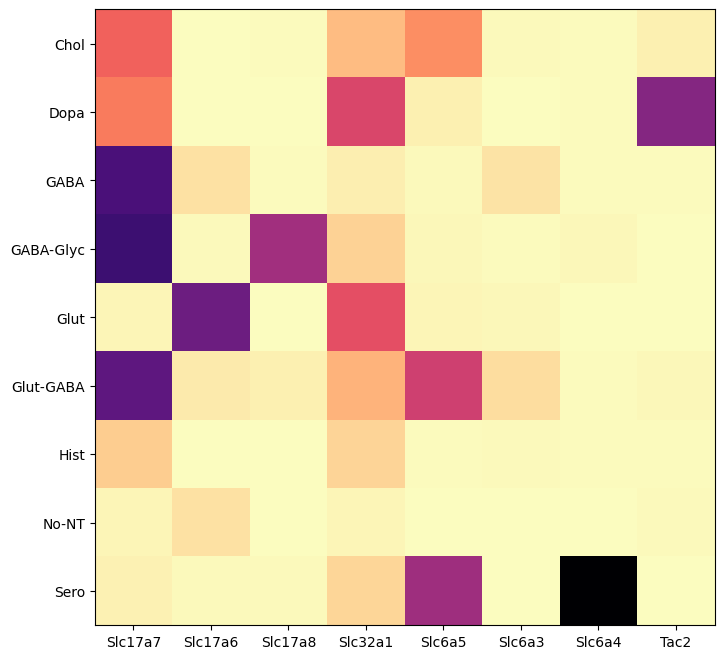

In [118]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'neurotransmitter_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

Below is by dissection region of interest shows that each of these genes are associated with distinct regions.

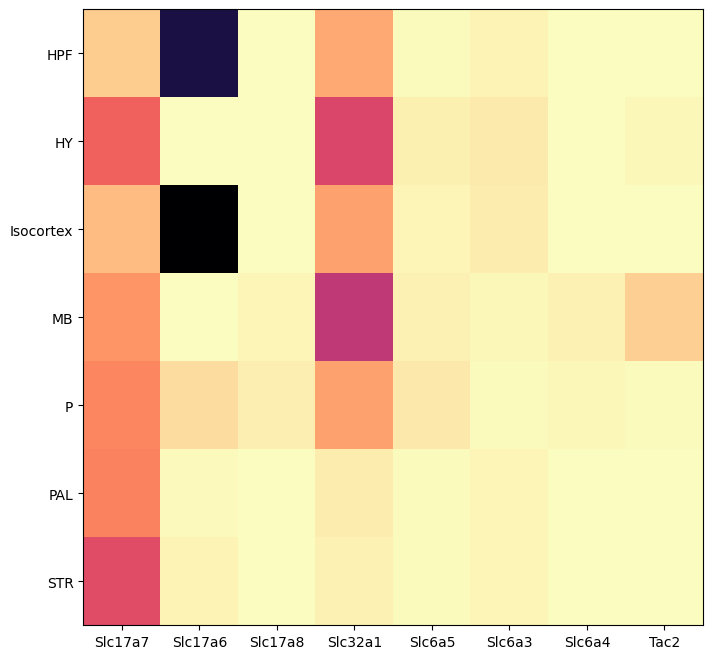

In [119]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'anatomical_division_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

And finally by supercluster from the taxonomy.

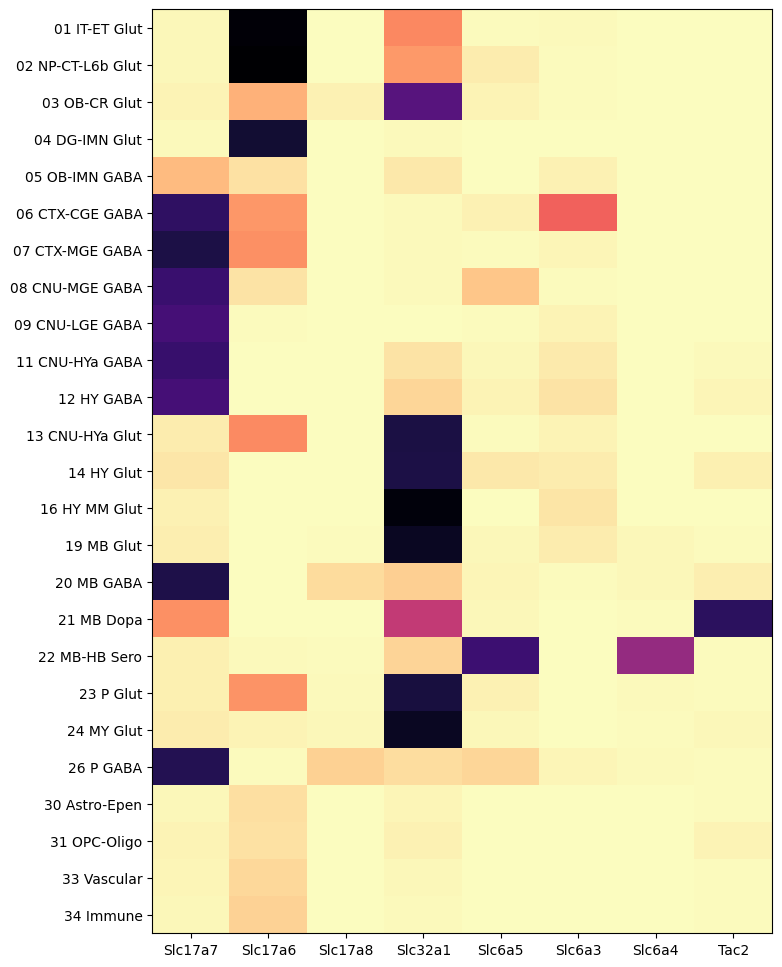

In [120]:
agg = aggregate_by_metadata(cell_extended_with_genes, asubset.columns, 'class_name')
res = plot_heatmap(agg, 8, 12)
plt.show()

We can also visualize the relationship these genes and their location in the UMAP. Note again as in part one that Neurons and Non-neurons should be plotted seperately.

In [121]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

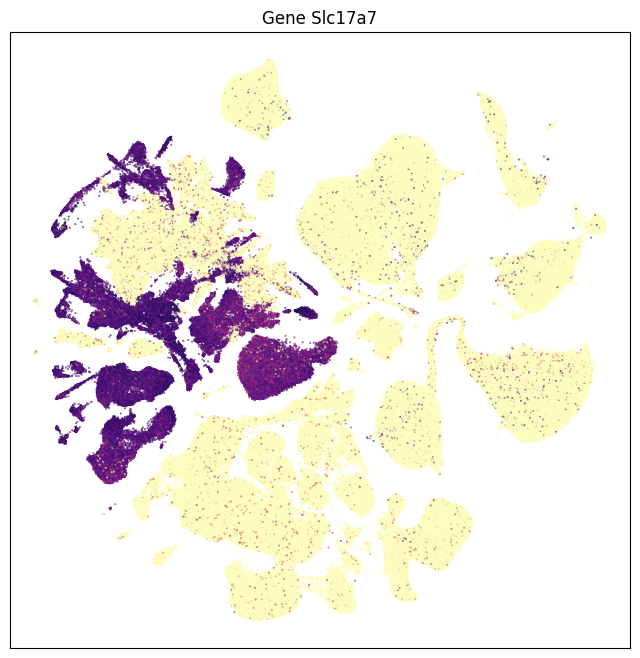

In [122]:
for gene_name in glist:
    fig, ax = plot_umap(
        cell_extended_with_genes['x'],
        cell_extended_with_genes['y'],
        val=cell_extended_with_genes[gene_name],
        cmap=plt.cm.magma_r)
    res = ax.set_title(f"Gene {gene_name}")
    plt.show()
    break

## AgeDE Genes

In [123]:
degenes = pd.read_csv(taxonomy_base / 'aging_degenes.csv' )
degenes

,grouping_type,grouping_label,grouping_name,gene_identifier,gene_symbol,is_primary_ieg,age_effect_size,unadjusted_pvalue,adjusted_pvalue,confidence_interval_higher_bound,confidence_interval_lower_bound
0,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000073590,3222401L13Rik,False,1.812935,7.766049e-12,9.653199e-08,2.346020,1.279850
1,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000095041,AC149090.1,False,1.289552,3.322308e-17,4.129629e-13,1.793447,0.785656
2,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000086503,Xist,False,1.185049,2.222176e-11,2.762165e-07,1.645855,0.724244
3,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000073590,3222401L13Rik,False,1.867499,1.532389e-15,1.963297e-11,2.366093,1.368905
4,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000095041,AC149090.1,False,1.229435,4.989205e-25,6.392170e-21,1.589657,0.869213
...,...,...,...,...,...,...,...,...,...,...,...
6423,cluster,CS20241021_0388,388_PVH-SO-PVa Otp Glut_3,ENSMUSG00000073590,3222401L13Rik,False,3.274070,1.071906e-07,1.307511e-03,4.268833,2.279307
6424,cluster,CS20241021_0388,388_PVH-SO-PVa Otp Glut_3,ENSMUSG00000070348,Ccnd1,False,-2.575602,7.636870e-07,9.315454e-03,-1.475552,-3.675652
6425,cluster,CS20241021_0388,388_PVH-SO-PVa Otp Glut_3,ENSMUSG00000025658,Cnksr2,False,-2.525286,4.681401e-07,5.710373e-03,-1.064118,-3.986455
6426,cluster,CS20241021_0388,388_PVH-SO-PVa Otp Glut_3,ENSMUSG00000031618,Nr3c2,False,-1.300761,5.438041e-08,6.633322e-04,-0.888016,-1.713506


In [124]:
mapping = pd.read_csv(taxonomy_base / 'cluster_mapping_pivot.csv' )
mapping

,cluster_alias,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color
0,1,CS20241021_0001,0,1_CLA-EPd-CTX Car3 Glut_1,#f7c27a,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,#FA0087,#64c2fc,#99822E
1,2,CS20241021_0002,1,2_IT EP-CLA Glut_1,#5c1a34,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
2,3,CS20241021_0003,2,3_IT EP-CLA Glut_1,#b96cf0,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
3,4,CS20241021_0004,3,4_IT EP-CLA Glut_1,#bff691,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
4,5,CS20241021_0005,4,5_IT EP-CLA Glut_1,#39fbfa,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
...,...,...,...,...,...,...,...,...,...,...,...
842,843,CS20241021_0843,842,843_Microglia NN_1,#a88b30,34 Immune,334 Microglia NN,1194 Microglia NN_1,#825f45,#CC1F4E,#62CC3D
843,844,CS20241021_0844,843,844_Microglia NN_1,#df92c3,34 Immune,334 Microglia NN,1194 Microglia NN_1,#825f45,#CC1F4E,#62CC3D
844,845,CS20241021_0845,844,845_BAM NN_1,#a1adea,34 Immune,335 BAM NN,1195 BAM NN_1,#825f45,#66493D,#32662E
845,846,CS20241021_0846,845,846_DC NN_1,#9a5824,34 Immune,337 DC NN,1197 DC NN_1,#825f45,#CCA27A,#FF999F


In [125]:
cols = ['supertype_name','class_color']
color_map = mapping[cols].copy()
color_map.drop_duplicates( inplace = True )
color_map.set_index('supertype_name', inplace=True)

grouped = degenes.groupby(['grouping_type','grouping_name'])['gene_symbol'].count()['supertype']
grouped

grouping_name
1159 Astro-NT NN_1            7
1160 Astro-NT NN_2           63
1161 Astro-TE NN_1           44
1163 Astro-TE NN_3           49
1165 Astro-TE NN_5          169
1171 Astroependymal NN_3     41
1173 Tanycyte NN_2          367
1175 Ependymal NN_1         155
1179 OPC NN_1                45
1181 COP NN_1                23
1183 MFOL NN_3               19
1184 MOL NN_4               315
1186 ABC NN_1                32
1187 VLMC NN_1               53
1188 VLMC NN_2               46
1191 Peri NN_1               42
1192 SMC NN_1                34
1193 Endo NN_1              103
1194 Microglia NN_1         180
1195 BAM NN_1               118
Name: gene_symbol, dtype: int64

Text(0.5, 1.0, 'Number of aging DEG : non-neuronal supertypes')

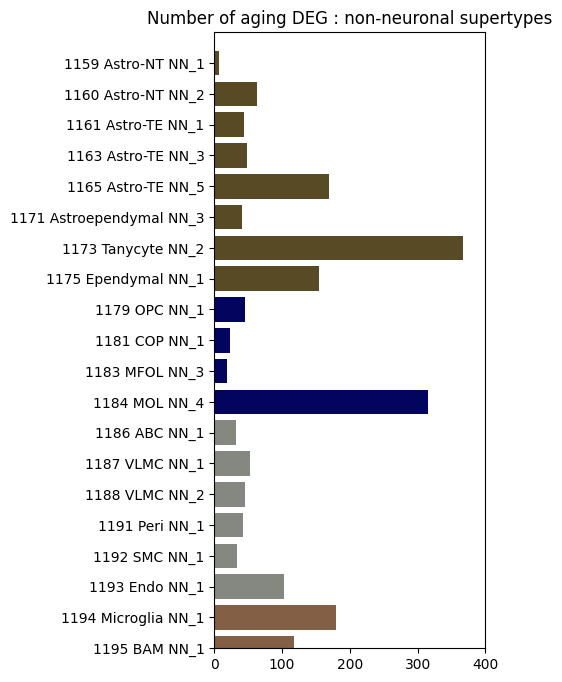

In [126]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 8)
counts = grouped.values
names = grouped.index.values
colors = color_map.loc[names,'class_color'].values
ax.barh(names[::-1], counts[::-1], color = colors[::-1], )
ax.set_xlim([0,400])
ax.set_ylim([0,len(names)])
ax.set_title('Number of aging DEG : non-neuronal supertypes')

In [127]:
cols = ['subclass_name','class_color']
color_map = mapping[cols].copy()
color_map.drop_duplicates( inplace = True )
color_map.set_index('subclass_name', inplace=True)

grouped = degenes.groupby(['grouping_type','grouping_name'])['gene_symbol'].count()['subclass']
grouped

grouping_name
001 CLA-EPd-CTX Car3 Glut        56
002 IT EP-CLA Glut               32
003 L5/6 IT TPE-ENT Glut         88
004 L6 IT CTX Glut               41
005 L5 IT CTX Glut               42
                                 ..
273 PDTg-PCG Pax6 Gaba           19
274 PDTg Otp Shroom3 Gaba        12
275 PDTg Otp Olig3 Gaba          19
276 LDT-PCG St18 Gaba            12
277 DTN-LDT-IPN Otp Pax3 Gaba    10
Name: gene_symbol, Length: 132, dtype: int64

Text(0.5, 1.0, 'Number of aging DEG : neuronal subclass')

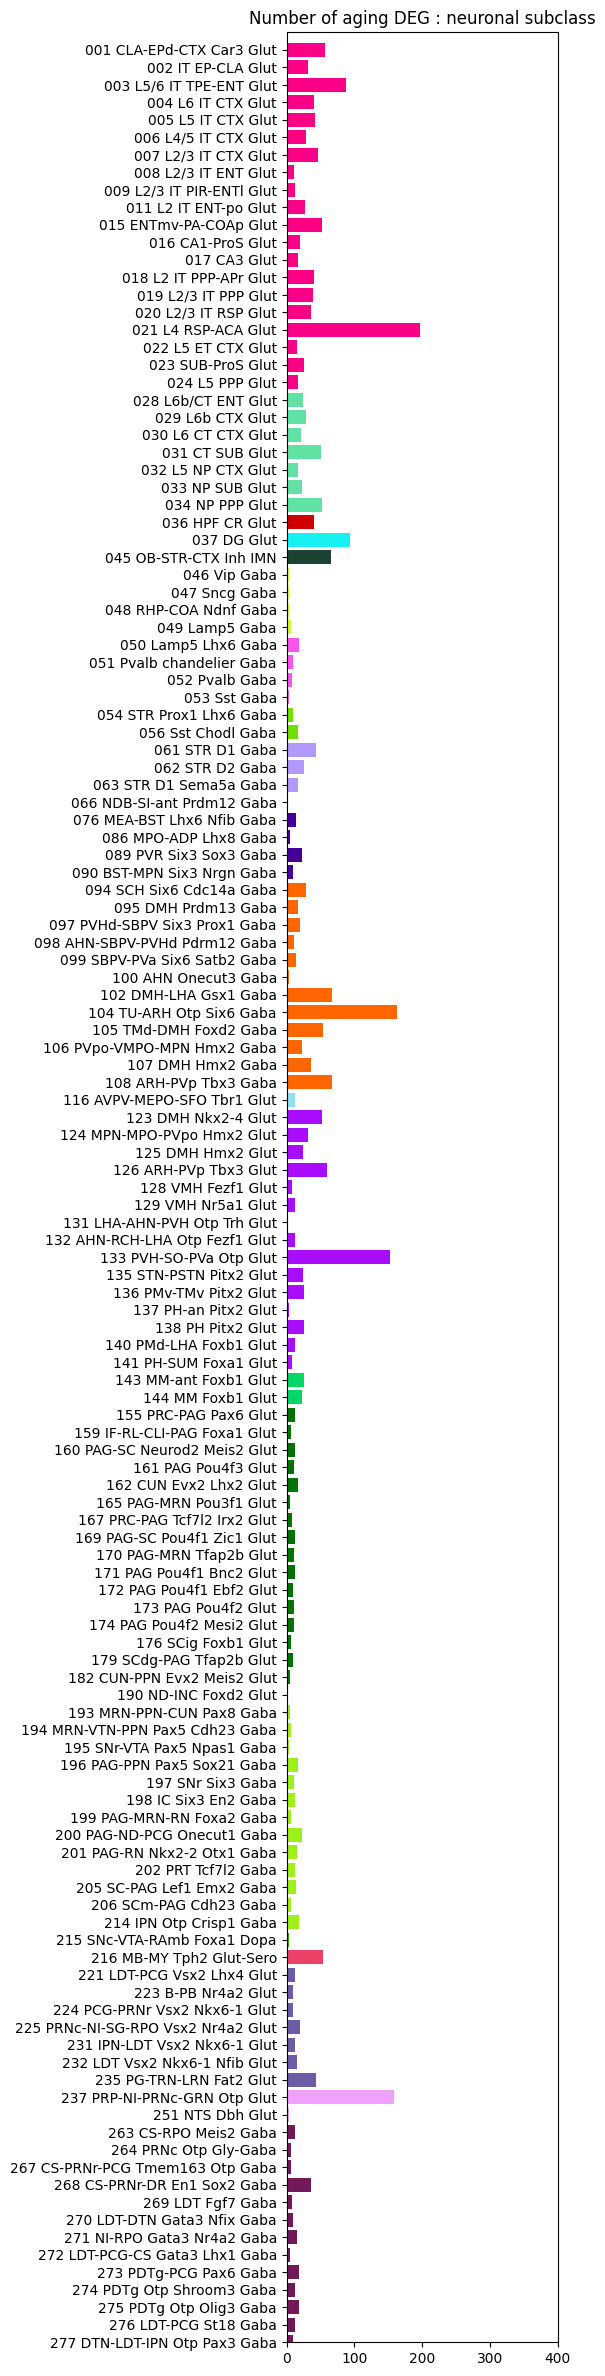

In [128]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 30)
counts = grouped.values
names = grouped.index.values
colors = color_map.loc[names,'class_color'].values
ax.barh( names[::-1], counts[::-1], color = colors[::-1] )
ax.set_xlim([0,400])
ax.set_ylim([0,len(names)])
ax.set_title('Number of aging DEG : neuronal subclass')

In [132]:
degene_list = ['3222401L13Rik', 'Slc5a5', 'AC149090.1', 'Ccnd1', 'Ccnd2']
subclass_degenes = degenes[degenes['grouping_type'] == 'subclass']
subclasses = sorted(subclass_degenes['grouping_name'].unique())
subclass_by_gene = pd.DataFrame(columns=degene_list, index=subclasses)
for idx, derow in subclass_degenes.iterrows():
    if derow['gene_symbol'] in degene_list:
        subclass_by_gene.loc[derow['grouping_name'], derow['gene_symbol']] = derow['age_effect_size']

In [133]:
subclass_by_gene

,3222401L13Rik,Slc5a5,AC149090.1,Ccnd1,Ccnd2
001 CLA-EPd-CTX Car3 Glut,NaN,NaN,1.614551,NaN,NaN
002 IT EP-CLA Glut,NaN,1.096541,NaN,-2.573835,-1.277657
003 L5/6 IT TPE-ENT Glut,NaN,1.253065,1.909579,-1.420208,NaN
004 L6 IT CTX Glut,NaN,NaN,1.535055,-1.5732,-1.371331
005 L5 IT CTX Glut,NaN,1.886562,1.530523,NaN,NaN
...,...,...,...,...,...
273 PDTg-PCG Pax6 Gaba,1.092494,NaN,NaN,NaN,NaN
274 PDTg Otp Shroom3 Gaba,NaN,NaN,1.018284,NaN,NaN
275 PDTg Otp Olig3 Gaba,1.448016,1.001317,1.05693,NaN,NaN
276 LDT-PCG St18 Gaba,1.447515,NaN,1.101888,NaN,NaN


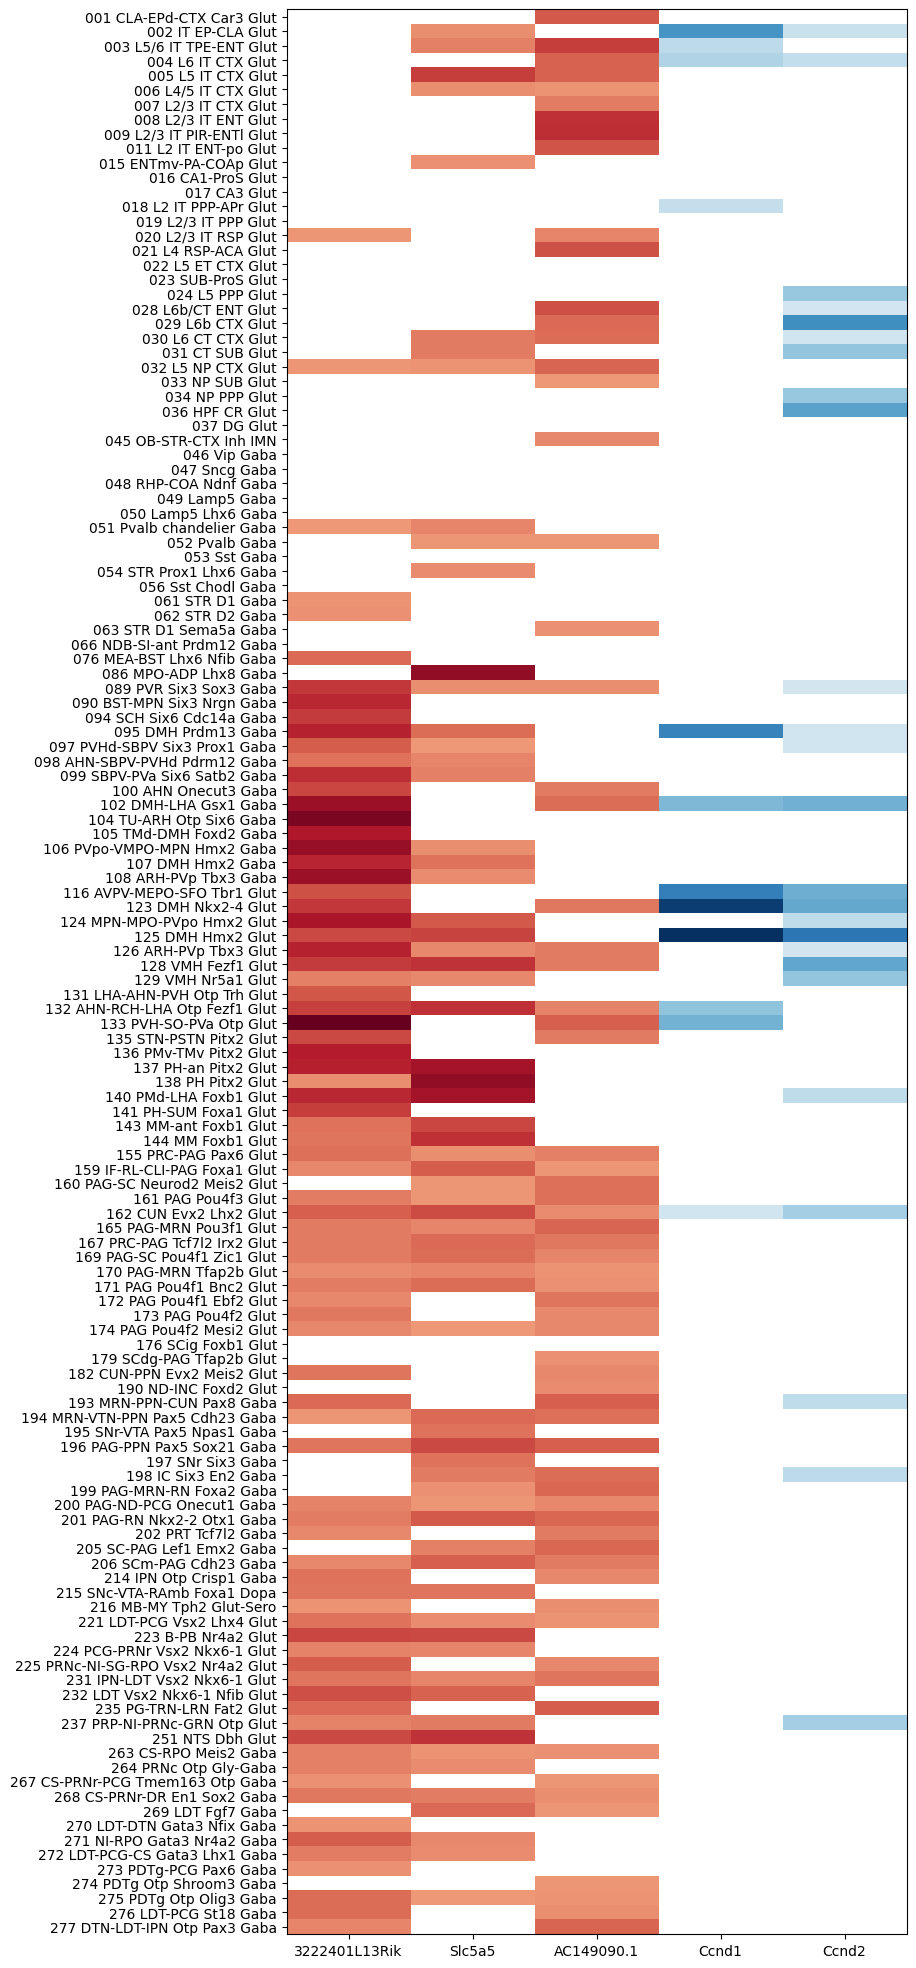

In [136]:
res = plot_heatmap(subclass_by_gene, 8, 25, cmap=plt.cm.RdBu_r, vmin=-4, vmax=4)
plt.show()